# Overview
In this notebook we are going to explore a simple application of the TCMC Layer on an a small educational forest.

We start by importing the needed libraries.

In [1]:
# as the library is in a different folder we modify the path of our python env.
import sys
sys.path.append("..")

# the base layer
from tcmc.tcmc import TCMCProbability

# libraries for numerical manipulation
import numpy as np
import tensorflow as tf

# python packages for visualization and in-memory examples
from Bio import Phylo
from io import StringIO
from tempfile import SpooledTemporaryFile as stf

And set up a small forest

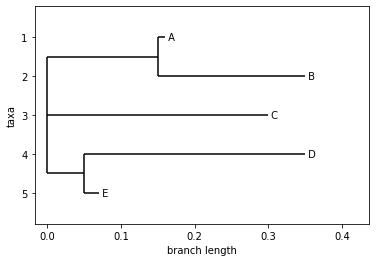

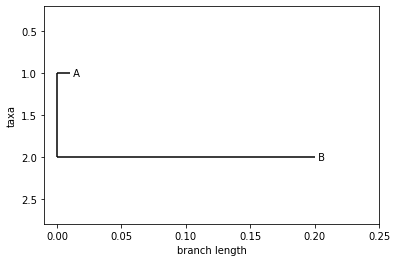

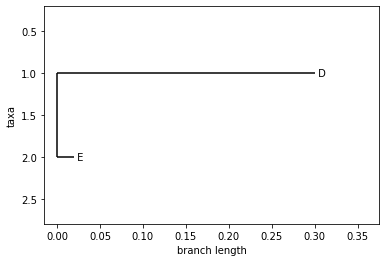

In [2]:
# define a set of trees in Newick format
str_tree = '((A:0.01,B:0.2):0.15,C:0.3,(D:0.3,E:0.02):0.05);'
str_tree_prune1 = '(A:0.01,B:0.2);'
str_tree_prune2 = '(D:0.3,E:0.02);'

# plot these trees
tree = Phylo.read(StringIO(str_tree), 'newick')
tree_prune1 = Phylo.read(StringIO(str_tree_prune1), 'newick')
tree_prune2 = Phylo.read(StringIO(str_tree_prune2), 'newick')
Phylo.draw(tree)
Phylo.draw(tree_prune1)
Phylo.draw(tree_prune2)

## Prepare Model Parameters

### Parameter for Jukes-Cantor Model
A TCMC Model is parameterized by a set of rates $R$ and a stationairy distribution $\pi$.
These two data are used to generate the infinitesimal generator $Q$ of a Markov chain 
with $s \in \mathbb{N}$ states in the following way:
The matrix $Q \in \mathbb{R}^{s \times s}$ is obtained by
$$
    Q_{jk} = \begin{cases}
        R_{\text{min}\{j,k\}, \text{max}\{j,k\}} \cdot \pi_k & \text{, for } j \neq k \\
        - \sum_{l \neq j} Q_{jl} & \text{, for } j=k
    \end{cases}
$$
for $0 \leq j,k < s$

In our example we want to model transitions between nucleotides and therefore our state space has size $s = 4$.
Accordingly we need to specify a stationairy distribution $\pi \in \mathbb{R}^4$ and a rates vector $R \in \mathbb{R}^6$, where $6 = \frac{s(s-1)}{2}$.

In [3]:
s = 4 # our Markov chain has 4 states (the characters 'a', 'c', 'g' and 't')

# Normalized Jukes-Cantor parameters
rates = (4/3)*np.array([[1.,1.,1.,1.,1.,1.]])
stationairy_distribution = np.array([[.25,.25,.25,.25]])

## Initialize a TCMC Layer 

In [4]:
# usually you would save these trees in Newick files an use the paths
# as input for the TCMC layer. In our example we will use this strings
# as virtual files
forest = [StringIO(str_tree), StringIO(str_tree_prune1), StringIO(str_tree_prune2)]
N = 5 # the largest number of leaves in a single tree in our forest


# specify the input signature
# every leave configuration is given by a matrix with `N` rows and `s`
# columns, where the `i`-th row is a one-hot encoded state in our 
# space of `s` states.
leave_config_input = tf.keras.Input(shape=(N,s), dtype=tf.float64)
tree_ids_input = tf.keras.Input(shape=(), dtype=tf.int32)

# Build a TCMC Layer with one model (in our case Jukes-Cantor)
tcmc_model = TCMCProbability((1,), forest)

# This abstract layer does not yet know how many states the Markov
# chains will have. In order to do this we need to specify the 
# input shapes.
tcmc_model(leave_config_input, tree_ids_input)

# to be more precise, we could skip the previous step and already
# evaluate the layer on the test data. However the parameters for
# the model will be drawn randomly in the process. As we have a 
# specific model in mind, specifiying the shapes is necessary in
# order to allocate space for the model parameters.
# Hence we are now ready to set the parameters for our Jukes-Cantor
# model.
tcmc_model.stationairy_distribution = stationairy_distribution
tcmc_model.rates = rates

## Investigate the Model

### The Infinitesimal Generator (Transition Rate Q-Matrix)

In [5]:
# The infinitesimal generators of the Markov chains
# in our model is calculated on demand from our parameters.
# We may retrieve them by:
tcmc_model.generator

# Our model is already normalized to one expected mutation.
# You can uncomment the following lines to define a non-
# normlized version of Jukes-Cantor and compare the 
# generator and its normalization.

# tcmc_model.rates = np.array([[1.,1.,1.,1.,1.,1.]])
# print(f'generator: \n{tcmc_model.generator}')
# print(f'normalized generator: \n{tcmc_model.normalized_generator}')

<tf.Tensor: shape=(1, 4, 4), dtype=float64, numpy=
array([[[-1.        ,  0.33333333,  0.33333333,  0.33333333],
        [ 0.33333333, -1.        ,  0.33333333,  0.33333333],
        [ 0.33333333,  0.33333333, -1.        ,  0.33333333],
        [ 0.33333333,  0.33333333,  0.33333333, -1.        ]]])>

### The Probability Distribution for a given Time Step
The probability distribution associated with a given transition rate matrix $Q$ can be obtained by using the matrix exponential.
More precisely given state-ids `a` and `b` the probability of reaching state `a` after a time-step $t$ whilst starting in state `b` is given by
$$P\left(X_{t_0 + t} = `a` \;\middle|\; X_{t_0} = `b`\right) = \exp(t \cdot Q)_{a,b}.$$
The matrices on the right-hand side can be evaluated for each model in the TCMC layer as in the following example

In [6]:
# evaluate the probability distribution of the model 
# at a given time step `t`
P = lambda t: tcmc_model.probability_distribution(t)

P(t=.02)

<tf.Tensor: shape=(1, 4, 4), dtype=float64, numpy=
array([[[0.98026431, 0.00657856, 0.00657856, 0.00657856],
        [0.00657856, 0.98026431, 0.00657856, 0.00657856],
        [0.00657856, 0.00657856, 0.98026431, 0.00657856],
        [0.00657856, 0.00657856, 0.00657856, 0.98026431]]])>

# Probability of a Leave Configuration
The main objective of the TCMC Layer is to infer likelyhoods of specific leave configurations in a tree given 
a Markov chain.
To be more precise assume $T = (T_1, \ldots, T_K)$ is the node set of the given tree.
given a configuration $\mathbf{t} = (\mathbf{t}_1, \ldots, \mathbf{t}_K)$ the probability of this configuration is modeled by
$$P(T = \mathbf{t};Q) = \pi_{\mathbf{t}_K} \cdot \prod_{e=(v,w) \text{ edge in T}} \exp\big(l(e) \cdot Q\big)_{\mathbf{t_w}, \mathbf{t_v}},$$
where $l(e)$ is the length of the edge $e$ in $T$.
If $L \subset T$ denotes the set of leave nodes in $T$ our goal is to infer the likelyhood $P(L = \mathbf{l})$ for any given leave configuration $\mathbf{l}$.
We shall now give an example of how to achive this using the TCMC layer.

## Declare Test Data
### The Leave Configuration
Assume in our first tree the leave nodes `A`, `B`, `C`, `D`, `E` are configured with nucleotides 
$$
\begin{align*}
A &= \text{a} \\
B &= \text{c} \\
C &= \text{c} \\
D &= \text{c} \\
E &= \text{g}.
\end{align*}
$$
As TCMC works with one-hot encoded states we would need to specify these in the form 
$$
\begin{align*}
A &= \begin{pmatrix} 1 & 0 & 0 & 0 \end{pmatrix} \\
B &= \begin{pmatrix} 0 & 1 & 0 & 0 \end{pmatrix} \\
C &= \begin{pmatrix} 0 & 1 & 0 & 0 \end{pmatrix} \\
D &= \begin{pmatrix} 0 & 1 & 0 & 0 \end{pmatrix} \\
E &= \begin{pmatrix} 0 & 0 & 1 & 0 \end{pmatrix}.
\end{align*}
$$
This configuration is stored in `leave_configurations[0,...]` below.

TCMC may be used with forest of vastly different node sizes. In order to give a well-defined
input shape, we must specify a configuration for $N$ nodes, where $N$ is the maximal number of
leaves in any of the considered trees.
In our case $N = 5$ (the first tree has 5 leaves, the remained two trees have $2$ leaves each).
If the number of leaves $n$ in any given tree is smaller than $N$ you will need to pad the remaining
$N - n$ rows with some values.
In our example the second tree only has $2$ leaves `A`, `B` which we will configure with the nucleotides `a` and `c` respectively.
For simplicity sake we will pad the remaing $5-2 = 3$ rows in its specification by `1`s.
This configuration can be inspected in `leave_configurations[1,...]`.

We proceed in a similar fashion for the configuration of our third batch entry for the third tree.

### The Batch Indices
An array `tree_ids` must be specified.
The `i`-th entry `tree_ids[i]` should be the id of the tree in the `forest` whose leave set is configured in `leave_configurations[i,...]`.

In [7]:
# some leave and partial leave configurations for trees in the forest
leave_configurations = tf.convert_to_tensor(np.array([
    [
        [1,0,0,0],
        [0,1,0,0],
        [0,1,0,0],
        [0,1,0,0],
        [0,0,1,0]
    ],
    [
        [1,0,0,0],
        [0,1,0,0],
        [1,1,1,1],
        [1,1,1,1],
        [1,1,1,1]
    ],
    [
        [0,1,0,0],
        [0,0,1,0],
        [1,1,1,1],
        [1,1,1,1],
        [1,1,1,1]
    ],
], dtype=np.float64))

# information which tree is used for which leave configuration in the batch
tree_ids = tf.convert_to_tensor(np.array([0,1,2], dtype=np.int32))

## Evaluate the Model
The likelyhood of the given batch of $3$ leave configurations can now easily be infered.
The $i$-th entry `tcmc_model(leave_configurations, tree_ids)[i]` will be the probability 
$$P\big(L^{\text{tree_ids}[i]} = \text{leave_configuration[i]}\big)$$
of the $i$-th leave configuration in the leave set $L^{\text{tree_ids}[i]}$ of the tree with id $\text{tree_ids}[i]$ in the forest.

In [8]:
tcmc_model(leave_configurations, tree_ids)

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[1.24065229e-05],
       [1.52635162e-02],
       [2.17074327e-02]])>